In [1]:
import os

import pandas as pd
import numpy as np
import metrics

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

import preprocessing

In [233]:
model = 'nbsinDDE'

In [9]:
!time g++ -Wall -std=c++11 -O3 src/*.cpp -o ./bin/sgd


real	0m4.883s
user	0m4.624s
sys	0m0.228s


In [10]:
!time ./bin/sgd data/mrh chargeDDEA

Loading config file : data/mrh/chargeDDEA.cfg
Lodading data file : data/mrh/features.dat
Lodading data file : data/mrh/exposure.dat
Lodading data file : data/mrh/target_chargeDDEm.dat
130071

Fit Model for 6 variables with 10000000 iterations :
0th iteration : rmse(train=1203.83, test=1206.68) | gini(train=0.0914206, test=0.093206)
Diff of coeffs : inf
924630 : Removing AUTV_k8000_o 39  Norm2=1.98144e-06
942760 : Removing AUTA_rm_6070 92  Norm2=6.44027e-05
960890 : Removing AUTV_rm 26  Norm2=9.10878e-05
979020 : Removing AUTA_rm_sup90 95  Norm2=8.54399e-05
997150 : Removing AUTV_nb_vol_gh 60  Norm2=0.000119388
1015280 : Removing AUTV_nb_rc_12 52  Norm2=0.000131248
1033410 : Removing AUTV_segment_b 48  Norm2=0.000151854
1051540 : Removing AUTV_nb_vol 99  Norm2=0.000210212
1069670 : Removing AUTV_prix_sra_jl 43  Norm2=0.000192897
1087800 : Removing AUTA_rm_7090 93  Norm2=0.000205426
1105930 : Removing AUTV_nb_vol_ij 61  Norm2=0.000241426
1124060 : Removing CLI_nb_contrat_pf 81  Norm2=0.0

3988600 : Removing Zone_inc_cm_iris 152  Norm2=0.00552112
4079250 : Removing CLI_cspf 127  Norm2=0.00576102
4169900 : Removing HAB_anclg 131  Norm2=0.00622432
4260550 : Removing CLI_banque 29  Norm2=0.00645891
4351200 : Removing vol_quant_cm_20 144  Norm2=0.00688899
4441850 : Removing HAB_cdresid 33  Norm2=0.0070538
4532500 : Removing HAB_habit_X_qual_X_inhab 124  Norm2=0.00721952
4623150 : Removing POL_distrib_code 151  Norm2=0.00752201
4713800 : Removing HAB_habit_nbpieces 149  Norm2=0.00776778
4804450 : Removing HAB_nb_pieces 85  Norm2=0.00875636
4895100 : Removing ddem_quant_cm_20 141  Norm2=0.00984485
4985750 : Removing HAB_inhab 97  Norm2=0.0104865
5076400 : Removing AUTV_prix_sra_supo 45  Norm2=0.011035
5439000th iteration : rmse(train=1196.64, test=1199.67) | gini(train=0.0989448, test=0.0985139)
Diff of coeffs : 0.000794599
7252000th iteration : rmse(train=1200.06, test=1203.09) | gini(train=0.100752, test=0.100141)
Diff of coeffs : 0.000570302
9065000th iteration : rmse(train

mean: 0.044381 0.044276
rmse: 0.214578
gini: 0.41261693360864105
deviance: 12.175579408828309


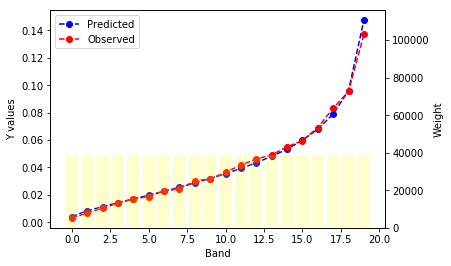

In [236]:
df = pd.read_csv("./data/results.csv")
print('mean:', round(np.sum(df.prediction) / np.sum(df.exposure), 6), round(np.sum(df.target) / np.sum(df.exposure), 6))
print('rmse:', round(metrics.root_mean_square_error(df.target, df.prediction, df.exposure), 6))
print('gini:', metrics.gini_emblem_fast(df.target, df.prediction, df.exposure))
print('deviance:', np.log(metrics.poisson_deviance(df.target, df.prediction, df.exposure)))
metrics.plot_lift_curve(df.target, df.prediction, df.exposure, n_band=20)

In [237]:
metadata = preprocessing.Metadata("data", "mrh")
metadata.load()

Loaded metadata from  data/mrh/metadata.json


In [238]:
n = metadata.size
p = metadata.count_features()
def load_data(file_path, dtype='int32', shape=None):
    return np.memmap(file_path, dtype=dtype, shape=shape)

data = load_data(metadata.get_feature_filename(), dtype=np.dtype('u1'), shape=(n, p))

In [239]:
df_coeffs = pd.read_csv('data/mrh/coeffs.csv').as_matrix()
df_coeffs = np.exp(df_coeffs)

def get_coeffs(feature_range):
    return df_coeffs[1 + np.array(feature_range)]    

In [240]:
test_data = data[df.row,:]

Error ploting relativity chart for  CLI_banque
Length of values does not match length of index
data/mrh/nbsinDDE/relativity_POL_cdopmrh.png


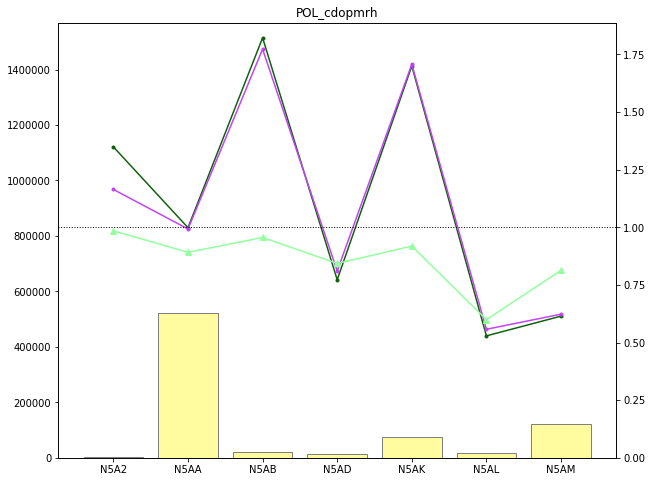

data/mrh/nbsinDDE/relativity_CLI_sex.png


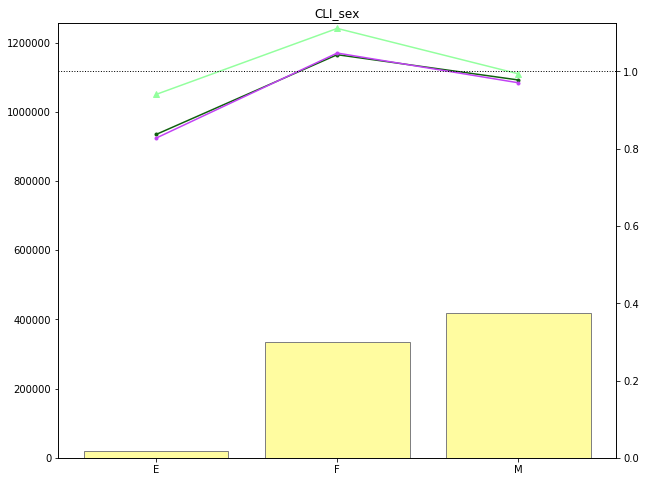

data/mrh/nbsinDDE/relativity_AUTV_nb_rc_78.png


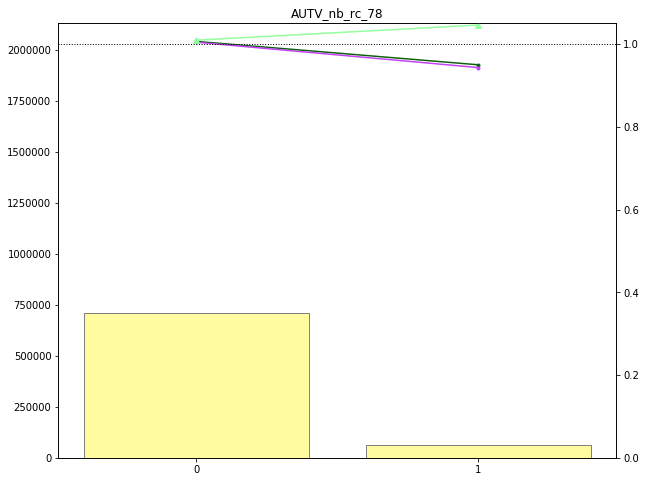

Error ploting relativity chart for  AUTA_tot1a
Length of values does not match length of index
Error ploting relativity chart for  AUTA_tot2a
Length of values does not match length of index
Error ploting relativity chart for  AUTA_tot3a
Length of values does not match length of index
Error ploting relativity chart for  AUTA_tot4a
Length of values does not match length of index
data/mrh/nbsinDDE/relativity_POL_tr_capass.png


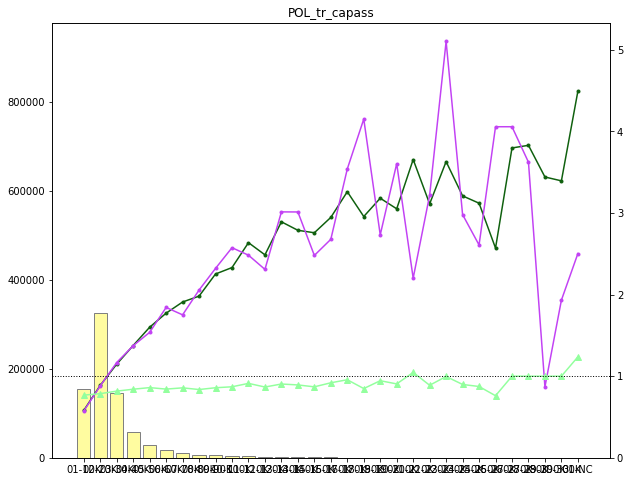

Error ploting relativity chart for  CLI_age
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_atr
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_aup
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_bqe
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_epa
Length of values does not match length of index
data/mrh/nbsinDDE/relativity_CLI_nb_contrat_hab.png


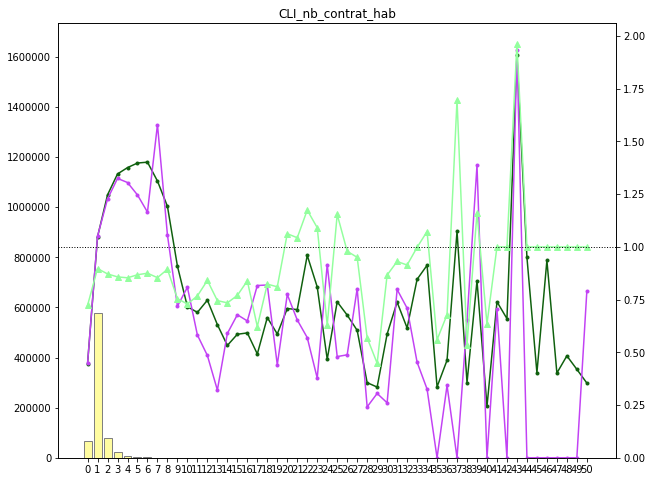

Error ploting relativity chart for  CLI_nb_contrat_mot
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_mrp
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_pf
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_pju
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_prv
Length of values does not match length of index
Error ploting relativity chart for  CLI_nb_contrat_san
Length of values does not match length of index
data/mrh/nbsinDDE/relativity_HAB_nb_pieces.png


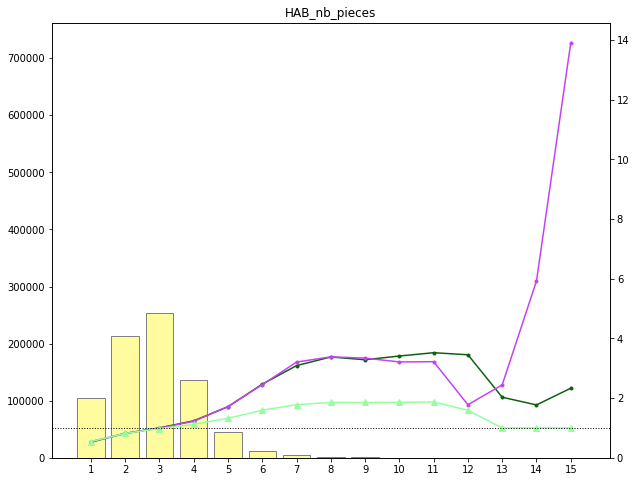

data/mrh/nbsinDDE/relativity_HAB_qual.png


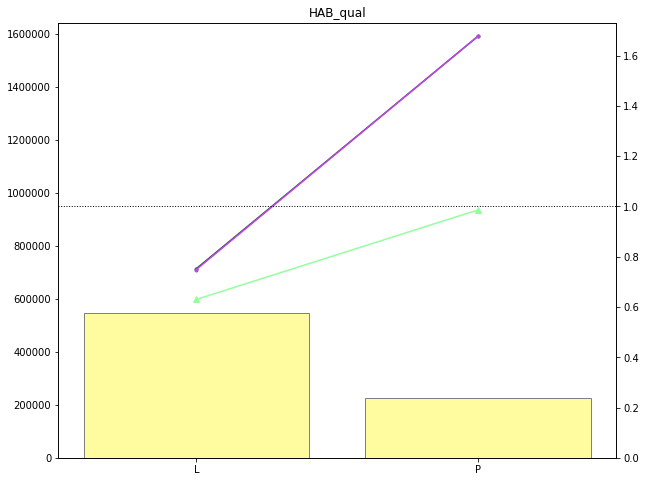

data/mrh/nbsinDDE/relativity_HAB_habit_X_qual_X_inhab.png


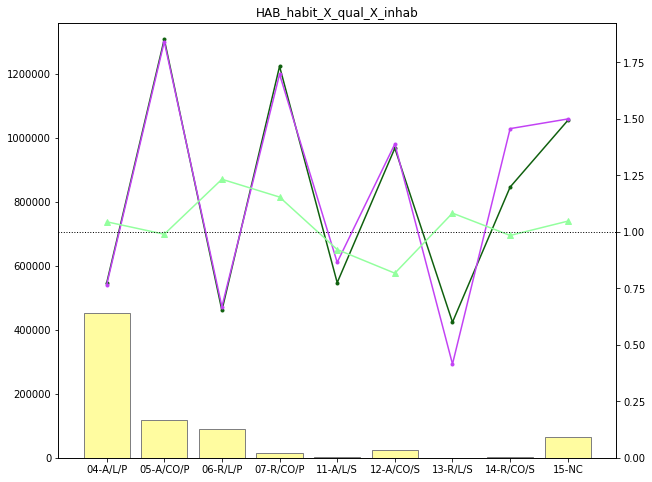

data/mrh/nbsinDDE/relativity_ddea_quant_freq_20.png


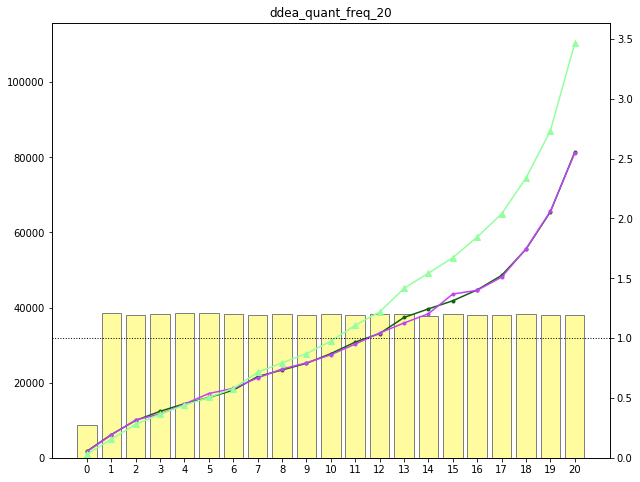

data/mrh/nbsinDDE/relativity_ddem_quant_freq_20.png


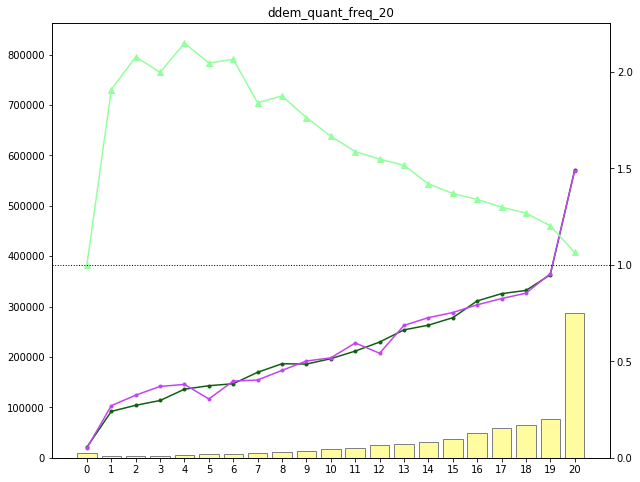

data/mrh/nbsinDDE/relativity_ddem_quant_cm_20.png


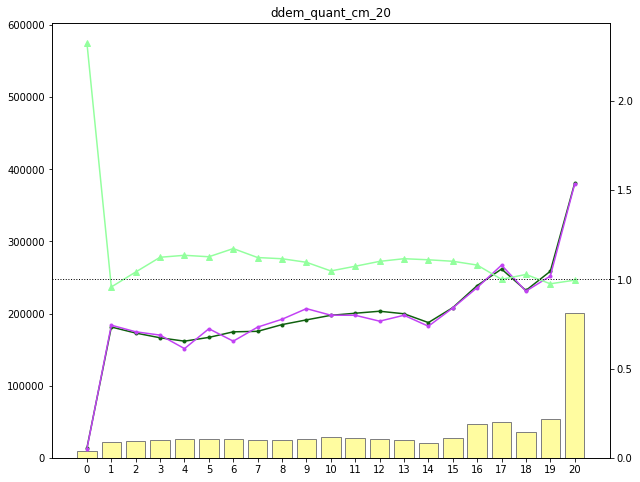

In [241]:
def plot_relativities(df, model, feature, idx, modalities):
    try:
        modalities = [float(m) for m in modalities]
        if sum([m - int(m) for m in modalities]) == 0:
            modalities = [int(m) for m in modalities]
    except:
        pass
    
    df['f'] = test_data[:, idx]

    m = df.target.mean()
    relativity = df.groupby(['f']).agg({'exposure': 'sum', 'target': 'mean', 'prediction': 'mean'})
    relativity.target /= m
    relativity.prediction /= m
    relativity['one'] = 1
    relativity['modalities'] = modalities
    relativity['coeffs'] = get_coeffs(metadata.get_feature_range(feature))
    if(relativity['coeffs'].sum() == relativity['coeffs'].count()):
        return
    relativity = relativity.sort_values('modalities')
    size = relativity.prediction.size
    ar = np.arange(size)
    
    max_exposure = relativity.exposure.max()
    
    fig, ax1 = plt.subplots(figsize=(10, 8))

    ax1.bar(ar, relativity.exposure, color='#fffca0', edgecolor='grey')
    ax1.set_ylim(ymax=max_exposure * 3)
    ax1.set_xticks(ar)
    ax1.set_xticklabels(labels=relativity.modalities)
  
    ax2 = ax1.twinx()
    ax2.set_title(feature)
    ax2.plot(ar, relativity.prediction, color="#0f600e", marker=".")
    ax2.plot(ar, relativity.target, color="#c242f4", marker=".")
    ax2.plot(ar, relativity.coeffs, color="#93ff9e",marker="^")
    ax2.axhline(y=1, color='black', linewidth=1, linestyle="dotted")
    ax2.set_ylim(ymin=0)
    
    print(os.path.join(metadata.path, metadata.name, model, 'relativity_' + feature +'.png'))
    plt.savefig(os.path.join(metadata.path, metadata.name, model, 'relativity_' + feature +'.png'))
    plt.show()
    
for f in metadata.features:
    try:
        plot_relativities(df, model, f, metadata.get_feature_index(f), metadata.get_modalities(f))
    except Exception as e:
        print('Error ploting relativity chart for ', f)
        print(e)

In [ ]:
residuals = df.target - df.prediction
pearson_residuals = residuals / np.sqrt(df.prediction)
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(df.prediction, pearson_residuals)
plt.show()